In [1]:
import math

In [2]:
import pipe_pytools.polar_plot as pp
import pipe_pytools.tools as tl
import pipe_pytools.grid as gr

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
t,dt,cf,Re,Xmax,epsr,lx,Jm,lt,nsym,vell = tl.get_scp("lin0.scp")

In [22]:
cf,Xmax,epsr,lx,Jm,lt,nsym,VEL = tl.get_bcp("xmean.bcp")

In [29]:
vell /= vell.max()

In [7]:
x = gr.X(2**lx, Xmax)
r = gr.R(Jm, epsr)
th = gr.Th(2**lt, nsym)

In [8]:
Im = x.m
hx = x.h
yt = r.f
yt1 = r.f1
rt = r.n
rt1 = r.n1
Km = th.m
ht = th.h

In [50]:
t,dt,Dp,Re,Xmax,epsr,lx,Jm,lt,nsym,vel = tl.get_scp("../tw-Re2500-Xmax5.scp")

In [51]:
VEL = vel.copy()

In [52]:
VEL.T[:] = vel.T[1:-1].mean(0)

In [53]:
vel1 = vel - VEL

# Подгонка системы отсчета 

<matplotlib.contour.QuadContourSet instance at 0x7fa7bb50d6c8>

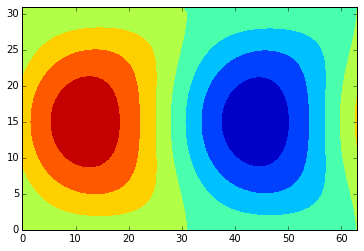

In [19]:
plt.contourf(vell[2,1:-1,10,1:-1])

<matplotlib.contour.QuadContourSet instance at 0x7fa7bb440440>

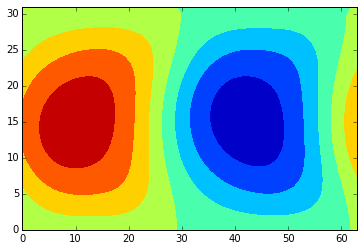

In [20]:
plt.contourf(vel1[2,1:-1,10,1:-1])

In [30]:
vell /= 21

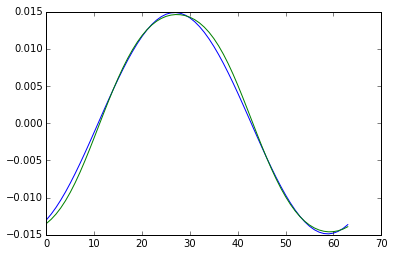

In [54]:
plt.plot(vell[2,16,10,1:-1])
plt.plot(vel1[2,16,10,1:-1])

In [48]:
vell_tmp = vell
vell = np.zeros_like(vell)

vell.T[1:16] = vell_tmp.T[-16:-1]
vell.T[16:-1] = vell_tmp.T[1:-16]

del vell_tmp

# Расчет завихрености

In [34]:
def bc(vel):
    u,v,w = vel
        
    vel[:,:,:,0] = vel[:,:,:,-2]
    vel[:,:,:,-1] = vel[:,:,:,1]
    
    for i in range(0,Im+1):
        for j in range(1,Jm+1):
            u.T[i,j,0] = u.T[i,j,1]
            u.T[i,j,Km+1] = u.T[i,j,Km]
            
        for k in range(1,Km+1):
            u.T[i,Jm+1,k] = - u.T[i,Jm,k]
            
    for k in range(1,Km+1):
        for i in range(1,Im+1):
            v.T[i,Jm,k] = 0.0
            
    for j in range(1,Jm+1):
        for i in range(1,Im+1):
            v.T[i,j,0] = v.T[i,j,1]
            v.T[i,j,Km+1] = v.T[i,j,Km]
            
    for j in range(1,Jm+1):
        for i in range(0,Im+2):
            w.T[i,j,0] = 0.0
            w.T[i,j,Km] = 0.0
            
    for k in range(0,Km+1):
        for i in range(1,Im+1):
            w.T[i,Jm+1,k] = - w.T[i,Jm,k] * yt[Jm] / yt[Jm+1]
            
    return vel

In [35]:
def rot(vel):
    bc(vel)
    u,v,w = vel
    
    om = np.zeros((3,Km+2,Jm+2,Im+2))
    ox,on,ot = om
    
    for i in range(1,Im+1):
        for j in range(1,Jm+1):
            for k in range(0,Km+1):
                w0 = w.T[i,j,k]
                w1 = w.T[i,j+1,k]
                v0 = v.T[i,j,k]
                v1 = v.T[i,j,k+1]
                ox.T[i,j,k] = ((yt[j+1]*w1 - yt[j]*w0) / rt1[j] - (v1 - v0) / ht) / rt[j]
                
        for j in range(0,1):
            for k in range(0,Km+1):
                ox.T[i,j,k] = 0.0
                
    for k in range(0,Km+1):
        for j in range(1,Jm+1):
            for i in range(0,Im+1):
                u0 = u.T[i,j,k]
                u1 = u.T[i,j,k+1]
                w0 = w.T[i,j,k]
                w1 = w.T[i+1,j,k]
                on.T[i,j,k] = (u1 - u0) / (yt[j] * ht) - (w1 - w0) / hx
                
    for k in range(1,Km+1):
        for j in range(1,Jm+1):
            for i in range(0,Im+1):
                u0 = u.T[i,j,k]
                u1 = u.T[i,j+1,k]
                v0 = v.T[i,j,k]
                v1 = v.T[i+1,j,k]
                ot.T[i,j,k] = (v1 - v0) / hx - (u1 - u0) / rt1[j]
    
    return om

In [36]:
oml = rot(vell)

In [37]:
om1 = rot(vel1)

In [38]:
om = rot(vel)

In [39]:
OM = rot(VEL)

In [40]:
def cs_mean(vel):
    res = 0.0
    ss = 0.0
    for k in range(1,Km+1):
        for j in range(1,Jm+1):
            res += vel[k,j]*yt[j]*yt1[j]*ht
            ss += yt[j]*yt1[j]*ht
            
    return res / ss

# Сравнение  

In [41]:
vell.max()

0.047619047619047616

<matplotlib.contour.QuadContourSet instance at 0x7fa7bb6ac878>

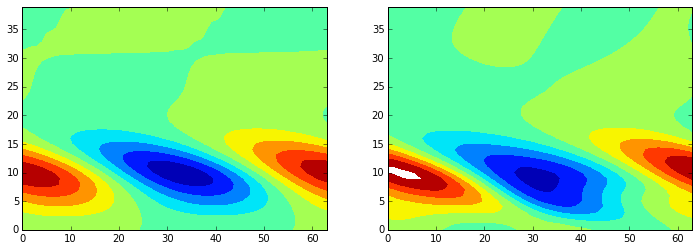

In [43]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.contourf(vell[0,8,1:-1,1:-1],np.linspace(-0.05,0.05,11))

plt.subplot(1,2,2)
plt.contourf(vel1[0,8,1:-1,1:-1],np.linspace(-0.05,0.05,11))

<matplotlib.contour.QuadContourSet instance at 0x7fa7bb5d5cb0>

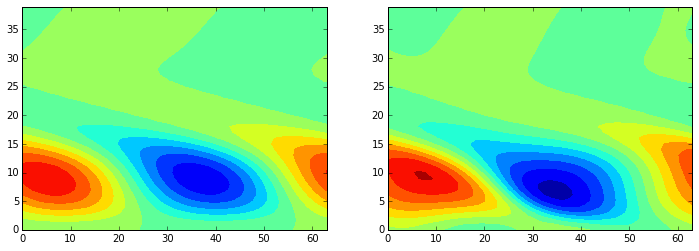

In [44]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.contourf(vell[0,1,1:-1,1:-1],np.linspace(-0.05,0.05,15))

plt.subplot(1,2,2)
plt.contourf(vel1[0,1,1:-1,1:-1],np.linspace(-0.05,0.05,15))

<matplotlib.contour.QuadContourSet instance at 0x7fa7b28eb290>

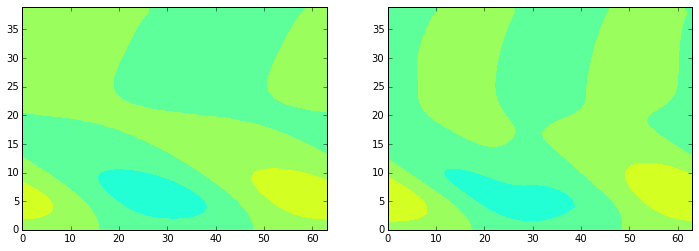

In [45]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.contourf(vell[1,1,1:-1,1:-1],np.linspace(-0.05,0.05,15))

plt.subplot(1,2,2)
plt.contourf(vel1[1,1,1:-1,1:-1],np.linspace(-0.05,0.05,15))

In [46]:
5.0 / 3

1.6666666666666667

<matplotlib.contour.QuadContourSet instance at 0x7fe169146b00>

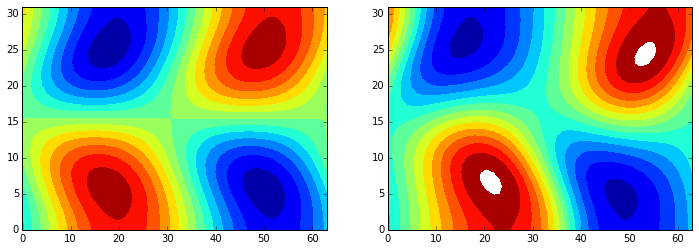

In [126]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.contourf(vell[0,1:-1,10,1:-1],np.linspace(-0.05,0.05,15))

plt.subplot(1,2,2)
plt.contourf(vel1[0,1:-1,10,1:-1],np.linspace(-0.05,0.05,15))

<matplotlib.contour.QuadContourSet instance at 0x7fe168fa9368>

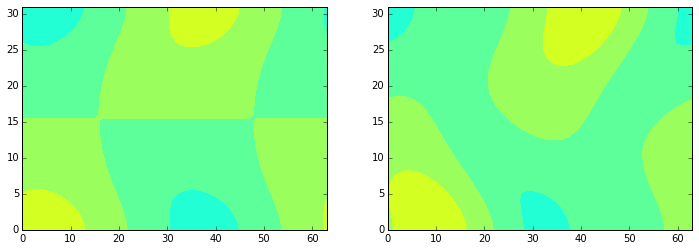

In [127]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.contourf(vell[1,1:-1,10,1:-1],np.linspace(-0.05,0.05,15))

plt.subplot(1,2,2)
plt.contourf(vel1[1,1:-1,10,1:-1],np.linspace(-0.05,0.05,15))

<matplotlib.contour.QuadContourSet instance at 0x7fe168df9b00>

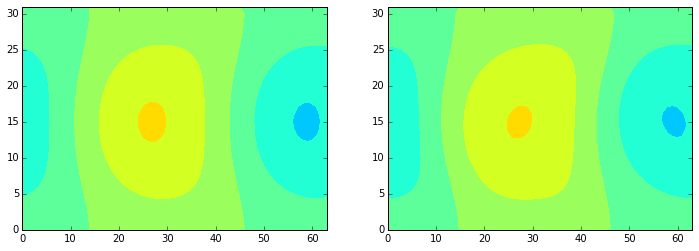

In [128]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.contourf(vell[2,1:-1,10,1:-1],np.linspace(-0.05,0.05,15))

plt.subplot(1,2,2)
plt.contourf(vel1[2,1:-1,10,1:-1],np.linspace(-0.05,0.05,15))

In [27]:
ox1max = om1[0].max()

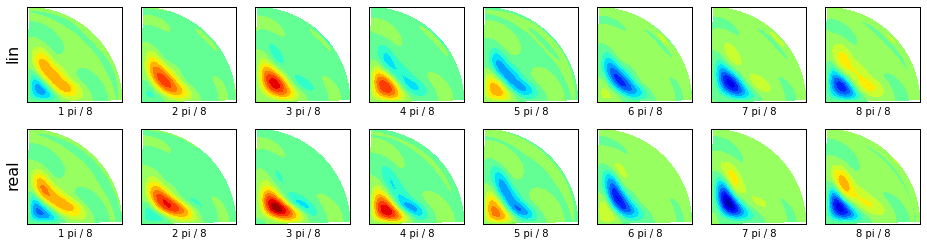

In [44]:
plt.figure(figsize=(16,4))
n=1
ff = True

for ii in range(1,65,8):
    
    plt.subplot(2,8,n)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], oml[0,1:-1,1:-1,ii], (-ox1max, ox1max))
    #pp.polar_arrow(vel[1,1:-1:3,1:-1:3,ii], lin[2,1:-1:3,1:-1:3,ii], r.f[1:-1:3], th.f[1:-1:3],2000)
    if ff:
        plt.ylabel("lin",fontsize=16)
    plt.xlabel("%d pi / 8" % n)
    
    plt.subplot(2,8,n+8)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], om1[0,1:-1,1:-1,ii], (-ox1max, ox1max))
    #pp.polar_arrow(vel[1,1:-1:3,1:-1:3,ii], vel1[2,1:-1:3,1:-1:3,ii], r.f[1:-1:3], th.f[1:-1:3],2000)
    if ff:
        plt.ylabel("real",fontsize=16)
        ff = False
    plt.xlabel("%d pi / 8" % n)
    n += 1

In [190]:
def comp(lv,v1):
    lmax = lv.max()
    max1 = v1.max()
    
    plt.figure(figsize=(16,4))
    n=1
    ff = True
    
    for ii in range(1,65,8):

        plt.subplot(2,8,n)
        pp.polar_contourf(yt[1:-1], th.f[1:-1], lv[1:-1,1:-1,ii], (-lmax, lmax))
        #pp.polar_arrow(vel[1,1:-1:3,1:-1:3,ii], lin[2,1:-1:3,1:-1:3,ii], r.f[1:-1:3], th.f[1:-1:3],2000)
        if ff:
            plt.ylabel("lin", fontsize=16)
        plt.xlabel("%d pi / 4" % n)

        plt.subplot(2,8,n+8)
        pp.polar_contourf(yt[1:-1], th.f[1:-1], v1[1:-1,1:-1,ii], (-max1, max1))
        #pp.polar_arrow(vel[1,1:-1:3,1:-1:3,ii], vel1[2,1:-1:3,1:-1:3,ii], r.f[1:-1:3], th.f[1:-1:3],2000)
        if ff:
            plt.ylabel("real", fontsize=16)
            ff = False
            
        plt.xlabel("%d pi / 4" % n)
            
        n += 1

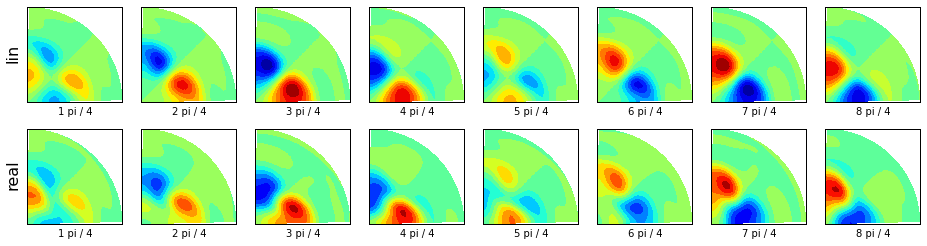

In [191]:
comp(vell[0],vel1[0])

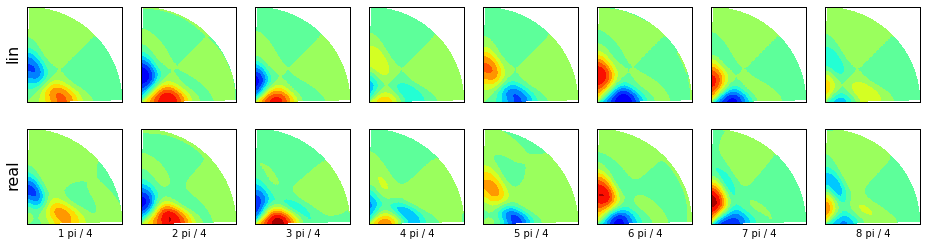

In [96]:
comp(vell[1],vel1[1])

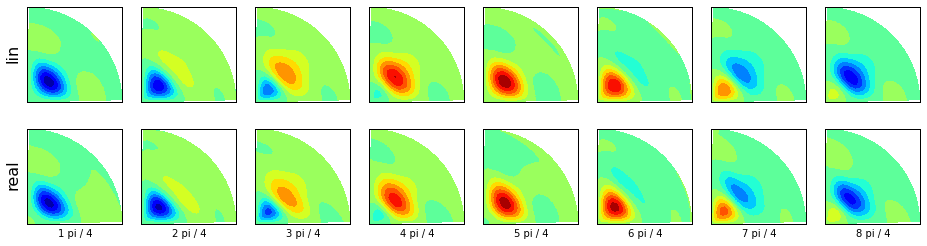

In [97]:
comp(vell[2],vel1[2])

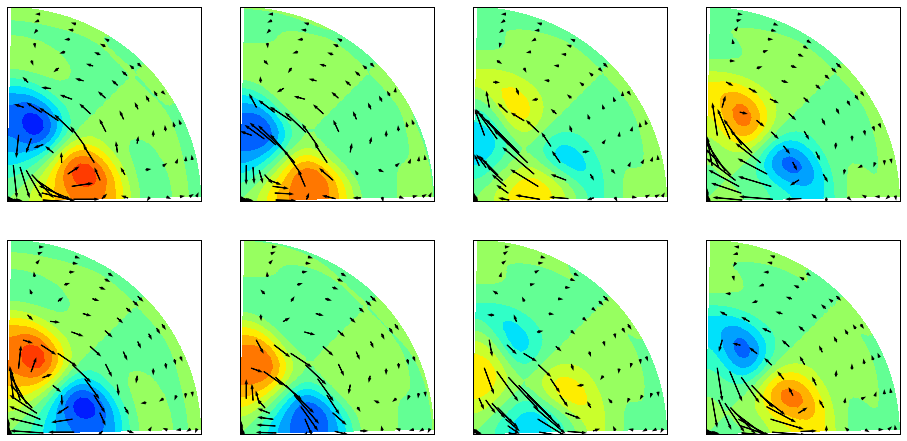

In [43]:
plt.figure(figsize=(16,16))
n=1
for ii in range(1,65,8):
    plt.subplot(4,4,n)
    n+=1
    pp.polar_contourf(yt[1:-1], th.f[1:-1], vel[0,1:-1,1:-1,ii], (-0.0003,0.0003))
    pp.polar_arrow(vel[1,1:-1:4,1:-1:4,ii], vel[2,1:-1:4,1:-1:4,ii], r.f[1:-1:4], th.f[1:-1:4],3000)